Este programa emplea la distribución de probabilidad exponencia para generar aleatoriamente los tiempos de llegada
de clientes a un establecimiento arbitrario, así como el tiempo que toma atenderlos.

Los parámetros son los siguientes:

* La tasa promedio de atención de clientes es de 15 clientes por hora, a través de 3 cajas.
* La tasa promedio de llegada de clientes es de 12 clientes por hora.

Se calculará, además:

1.	Cantidad de clientes totales atendidos en el día
2.	Tiempo de espera promedio por cliente
3.	Tiempo promedio de ocio por caja
4.	Máximo tiempo de espera de un cliente
5.	Mínimo tiempo de espera de un cliente
6.	Tiempo efectivo laborado por caja

Estos datos ayudarán a determinar si se debe mantener, incrementar o disminuir el número de cajas.

In [18]:
# Importación de librerías
import numpy
import simpy
import matplotlib.pyplot as plt
import datetime as dt
import os

**Nota:** la simulación se llevará a cabo en minutos

In [19]:
# Se define una semilla para el generador de números aleatorios, tal que se pueda reproducir la simulación
semilla = 0
numpy.random.seed(semilla)

In [20]:
# Funciones generadoras de variables aleatorias

# Usado para la simulación con la distribución exponencial
def generar_tiempo_llegada(lambda_llegada):
    return round(
        numpy.random.exponential(1 / lambda_llegada) * 60
    )

def generar_tiempo_atencion(lambda_atencion):
    # Obtener la tasa promedio de atención por caja por minuto
    return round(
        numpy.random.exponential(1 / lambda_atencion) * 60
    )

# Usado para la simulación con la distribución de Poisson
def generar_cantidad_clientes(lambda_llegada):
    return numpy.random.poisson(lambda_llegada / 60, 1)[0] # Se divide lambda_llegada entre 60 para obtener la tasa promedio de llegada por minuto

In [21]:
# Función para reportar el tiempo de la simulación en formato hh:mm
def desc_minutos(hora_inicio, minutos):
    return (
        dt.datetime.combine(dt.date.today(), hora_inicio) + dt.timedelta(minutes=minutos)
    ).strftime("%H:%M")

In [22]:
def decidir_mejor_caja(cajas):

    global tiempos_restantes
    # Seleccionar la caja que se desocupará primero

    menor_tiempo = tiempos_restantes[cajas[0]]
    mejor_caja = cajas[0]
    
    for caja in cajas:
        if tiempos_restantes[caja] < menor_tiempo:
            menor_tiempo = tiempos_restantes[caja]
            mejor_caja = caja

    return mejor_caja

In [23]:
def atender_cliente(entorno, id_cliente, caja, id_caja, tiempo_atencion, hora_inicio, archivo_resultados):

    # Se registra la llegada del cliente
    min_llegada = entorno.now
    msg_llegada = f"El cliente #{id_cliente} llega a la cola en el tiempo {desc_minutos(hora_inicio, min_llegada)}\n"
    
    if archivo_resultados:
        archivo_resultados.write(msg_llegada)
    else:
        print(msg_llegada)

    # Se registra el tiempo de atención del cliente en la caja
    tiempos_restantes[caja] += tiempo_atencion
    
    with caja.request() as peticion:

        # Se espera a ser atendido
        yield peticion

        # Se atiende al cliente
        min_atencion = entorno.now
        msg_atencion = f"El cliente #{id_cliente} es atendido en la caja #{id_caja} en el tiempo {desc_minutos(hora_inicio, min_atencion)}\n"
        if archivo_resultados:
            archivo_resultados.write(msg_atencion)
        else:
            print(msg_atencion)
        yield entorno.timeout(tiempo_atencion)

        # Se registra la salida del cliente
        global tiempos_efectivos
        tiempos_efectivos[caja] += tiempo_atencion
        global clientes_atendidos
        clientes_atendidos += 1
        msg_salida = f"El cliente #{id_cliente} termina de ser atendido a las {desc_minutos(hora_inicio, entorno.now)}\n"
        if archivo_resultados:
            archivo_resultados.write(msg_salida)
        else:
            print(msg_salida)
        
        # Se calcula el tiempo de espera
        tiempo_espera = min_atencion - min_llegada

        global espera_total
        espera_total += tiempo_espera

        global maxima_espera
        if tiempo_espera > maxima_espera:
            maxima_espera = tiempo_espera

        global minima_espera
        if tiempo_espera < minima_espera:
            minima_espera = tiempo_espera 

In [24]:
def sistema_colas_exponencial(entorno, lambda_llegada, lambda_atencion, cajas, hora_inicio, archivo_resultados):

    """
        Este proceso se encarga de atender a los clientes que llegan al sistema de colas.
        A través de una variable aleatoria de distribución exponencial, se determina el
        tiempo que tardará en llegar el siguiente cliente.
    """

    id_cliente = 0

    while True:

        yield entorno.timeout(generar_tiempo_llegada(lambda_llegada))
        
        id_cliente += 1
        global total_clientes
        total_clientes = id_cliente
        
        # Se selecciona la caja que se desocupará primero
        mejor_caja = decidir_mejor_caja(cajas)
        id_caja = cajas.index(mejor_caja) + 1

        # Se genera el tiempo de atención del cliente
        tiempo_atencion = generar_tiempo_atencion(lambda_atencion/len(cajas))
        
        # Se inicia el proceso de atención del cliente
        entorno.process(atender_cliente(entorno, id_cliente, mejor_caja, id_caja, tiempo_atencion, hora_inicio, archivo_resultados))

In [25]:
# Se declara el proceso que monitorea el estado de las cajas
def disminuir_tiempo_restante(entorno, cajas):

    """
        Este proceso se encarga de disminuir minuto a minuto el tiempo de atención restante de cada caja.
        Esto permite conocer con mayor precisión este dato, ya que en el proceso de atención de clientes
        únicamente se conoce el momento en el que la atención inicia y en el que termina, pero cuando llega
        un nuevo cliente no se puede conocer con exactitud cuánto progreso se ha hecho en la atención del
        cliente en turno, por lo que determinar la caja más óptima requiere de mayor precisión.

        * Nota: Si el tiempo de atención restante es 0, significa que la caja está desocupada, por lo que
        se deja de restar tiempo de atención restante.
    """
    
    while True:

        yield entorno.timeout(1)

        for caja in cajas:
            
            global tiempos_restantes
            tiempo_atencion_restante = tiempos_restantes[caja]
            
            if tiempo_atencion_restante > 0:
                tiempos_restantes[caja] -= 1 

In [26]:
def sistema_colas_poisson(entorno, lambda_llegada, lambda_atencion, cajas, hora_inicio, archivo_resultados):

    """
        Este proceso se encarga de atender a los clientes que llegan al sistema de colas.
        A través de una variable aleatoria de distribución de Poisson, se determina la
        cantidad de clientes que llegan en cada minuto.
    """

    id_cliente = 0
    cant_clientes = 0

    while True:

        yield entorno.timeout(1)
        
        # Se actualizan los tiempos restantes de atención de cada caja
        for caja in cajas:
            
            global tiempos_restantes
            tiempo_atencion_restante = tiempos_restantes[caja]
            
            if tiempo_atencion_restante > 0:
                tiempos_restantes[caja] -= 1

        # Se genera la cantidad de clientes que llegan en el minuto actual
        cant_clientes = generar_cantidad_clientes(lambda_llegada)
        
        # Se atienden los clientes que llegaron en el minuto actual
        for cliente in range(1, cant_clientes + 1):
            id_cliente += 1
            global total_clientes
            total_clientes = id_cliente

            # Se selecciona la caja que se desocupará primero
            mejor_caja = decidir_mejor_caja(cajas)
            id_caja = cajas.index(mejor_caja) + 1

            # Se genera el tiempo de atención del cliente
            tiempo_atencion = generar_tiempo_atencion(lambda_atencion/len(cajas))
            
            # Se inicia el proceso de atención del cliente
            entorno.process(atender_cliente(entorno, id_cliente, mejor_caja, id_caja, tiempo_atencion, hora_inicio, archivo_resultados))

In [27]:
def simular_exponencial(entorno, duracion_simulacion, lambda_llegada, lambda_atencion, cajas, hora_inicio, archivo_resultados):
    # Se asignan los procesos del sistema de colas y de monitoreo de cajas al entorno
    entorno.process(sistema_colas_exponencial(entorno, lambda_llegada, lambda_atencion, cajas, hora_inicio, archivo_resultados))          
    entorno.process(disminuir_tiempo_restante(entorno, cajas))
    # Se ejecuta la simulación hasta que se cumpla el tiempo indicado
    entorno.run(until=duracion_simulacion)

def simular_poisson(entorno, duracion_simulacion, lambda_llegada, lambda_atencion, cajas, hora_inicio, archivo_resultados):
    entorno.process(sistema_colas_poisson(entorno, lambda_llegada, lambda_atencion, cajas, hora_inicio, archivo_resultados))
    entorno.run(until=duracion_simulacion)


In [28]:
def ejecutar_simulacion(
    # Parámetros de la simulación
    entorno : simpy.Environment,
    duracion_simulacion : int,
    hora_inicio : dt.time,
    dist : str, # Distribución de probabilidad de llegada de clientes
    n_servidores : int,  # Número de cajas
    lambda_llegada : float,  # Tasa promedio de llegada de clientes por hora
    lambda_atencion : float, # Tasa promedio de atención de clientes por hora
    ruta_archivo_resultados : str = None, # Nombre del archivo de resultados
):

    """
        Esta función se encarga de ejecutar la simulación del sistema de colas, empleando como unidad de tiempo
        los minutos.
        
        Es posible indicar la distribución de probabilidad de llegada de clientes, ya sea exponencial
        (que calculará los tiempos que tardan en llegar un cliente tras otro) o de Poisson (que calculará
        la cantidad de clientes que llegan en un minuto).

        * Nota: Si la lambda está indicada en horas, se debe indicar el parámetro lambda_horas como verdadero.

        @param entorno: Entorno de simulación
        @param duracion_simulacion: Duración de la simulación en minutos
        @param dist: Distribución de probabilidad de llegada de clientes ("exp" o "poi")
        @param n_servidores: Número de cajas
        @param lambda_llegada: Tasa promedio de llegada de clientes por hora
        @param lambda_atencion: Tasa promedio de atención de clientes por hora
    """

    # Se crean las cajas
    cajas = [simpy.Resource(entorno, capacity=1) for i in range(n_servidores)]
    lambda_atencion_p_caja = lambda_atencion / n_servidores

    # Se declaran listas para almacenar información acerca de la simulación
    global total_clientes
    total_clientes = 0
    global clientes_atendidos
    clientes_atendidos = 0

    global espera_total
    espera_total = 0
    global maxima_espera
    maxima_espera = 0
    global minima_espera
    minima_espera = 0

    global tiempos_efectivos
    tiempos_efectivos = {}
    global tiempos_restantes # En este diccionario se almacena el tiempo de atención restante de cada caja
    tiempos_restantes = {}

    for caja in cajas:
        tiempos_efectivos[caja] = 0
        tiempos_restantes[caja] = 0

    # Se crea el archivo de resultados
    archivo_resultados = None

    try:
        if ruta_archivo_resultados:
            archivo_resultados = open(ruta_archivo_resultados, "w")
    except:
        raise Exception("No se pudo crear el archivo de resultados. Verifique que la ruta sea correcta.")

    # Se ejecuta la simulación de acuerdo a la distribución de probabilidad indicada
    if dist == "exp":
        simular_exponencial(entorno, duracion_simulacion, lambda_llegada, lambda_atencion, cajas, hora_inicio, archivo_resultados)
    elif dist == "poi":
        simular_poisson(entorno, duracion_simulacion, lambda_llegada, lambda_atencion, cajas, hora_inicio, archivo_resultados)
    else:
        raise Exception("Distribución no válida")

    # Se cierra el archivo de resultados
    if archivo_resultados:
        archivo_resultados.close()

In [29]:
# Se determina la duración de la simulación
hora_inicio = dt.time(7, 0, 0) # 7:00 am
hora_fin = dt.time(22, 0, 0) # 10:00 pm
duracion_simulacion = (hora_fin.hour - hora_inicio.hour) * 60 # Duración de la simulación en minutos

# Se ejecuta
ejecutar_simulacion(
    entorno = simpy.Environment(),
    duracion_simulacion = duracion_simulacion,
    hora_inicio = hora_inicio,
    dist = "exp", # Distribución de probabilidad de llegada de clientes ("exp" o "poi")
    n_servidores = 3,
    lambda_llegada = 12,
    lambda_atencion = 15,
)

El cliente #1 llega a la cola en el tiempo 07:04

El cliente #1 es atendido en la caja #1 en el tiempo 07:04

El cliente #2 llega a la cola en el tiempo 07:09

El cliente #2 es atendido en la caja #2 en el tiempo 07:09

El cliente #3 llega a la cola en el tiempo 07:12

El cliente #3 es atendido en la caja #3 en el tiempo 07:12

El cliente #4 llega a la cola en el tiempo 07:15

El cliente #2 termina de ser atendido a las 07:18

El cliente #4 es atendido en la caja #2 en el tiempo 07:18

El cliente #1 termina de ser atendido a las 07:19

El cliente #3 termina de ser atendido a las 07:24

El cliente #5 llega a la cola en el tiempo 07:32

El cliente #5 es atendido en la caja #1 en el tiempo 07:32

El cliente #5 termina de ser atendido a las 07:38

El cliente #6 llega a la cola en el tiempo 07:40

El cliente #6 es atendido en la caja #1 en el tiempo 07:40

El cliente #7 llega a la cola en el tiempo 07:44

El cliente #8 llega a la cola en el tiempo 07:44

El cliente #7 es atendido en la caja

In [30]:
# Se reportan los resultados de la simulación
print(f"🙂   Clientes que llegaron: {total_clientes}")
print(f"😊✨ Clientes que fueron atendidos: {clientes_atendidos}")
print(f"⌛    Tiempo promedio de espera: {int(espera_total/total_clientes)} minutos")
print(f"⌛😡  Máximo tiempo de espera: {maxima_espera} minutos")
print(f"⌛💚  Mínimo tiempo de espera: {minima_espera} minutos")
print(f"🔨    Tiempo efectivo laborado por caja:")

i = 1
for tiempo in tiempos_efectivos.values():
    print(f"\tCaja #{i}: {tiempo} min.")
    i += 1

print(f"😴   Tiempo de ocio por caja:")

i = 1
for tiempo in tiempos_efectivos.values():
    print(f"\tCaja #{i}: {duracion_simulacion - tiempo} min.")
    i += 1

🙂   Clientes que llegaron: 181
😊✨ Clientes que fueron atendidos: 177
⌛    Tiempo promedio de espera: 4 minutos
⌛😡  Máximo tiempo de espera: 33 minutos
⌛💚  Mínimo tiempo de espera: 0 minutos
🔨    Tiempo efectivo laborado por caja:
	Caja #1: 725 min.
	Caja #2: 657 min.
	Caja #3: 570 min.
😴   Tiempo de ocio por caja:
	Caja #1: 175 min.
	Caja #2: 243 min.
	Caja #3: 330 min.


In [31]:
# Se llevará a cabo una simulación para múltiples números de cajas, con el fin de determinar cuál es el número óptimo
# de cajas para el sistema, tanto para la distribución exponencial como para la de Poisson.

distribuciones = ("exp", "poi")
numeros_cajas = list(range(1,10,2)) # Se simulará con 1, 3, 5, 7 y 9 cajas

cants_clientes_atendidos = []
tiempos_promedio_espera = []
tiempos_efectivos_globales = []

variables_a_graficar = [
    ("Clientes atendidos según el número de cajas", cants_clientes_atendidos),
    ("Tiempo promedio de espera según el número de cajas", tiempos_promedio_espera),
    ("Tiempo efectivo laborado global según el número de cajas", tiempos_efectivos_globales),
]

In [32]:
def colores():
    yield "red"
    yield "green"
    yield "blue"
    yield "orange"
    yield "purple"
    yield "brown"
    yield "pink"
    yield "gray"
    yield "olive"
    yield "cyan"
    

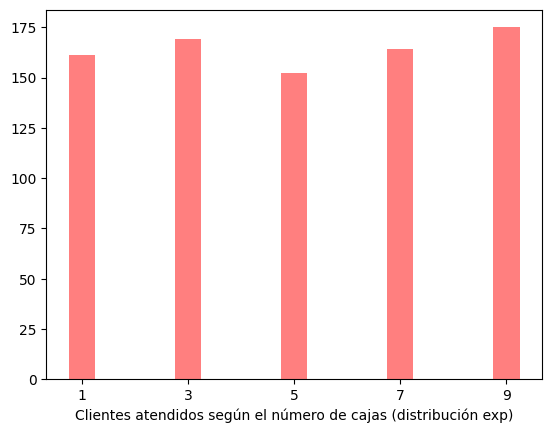

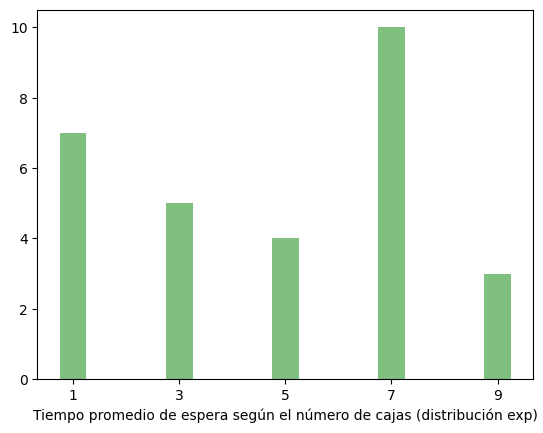

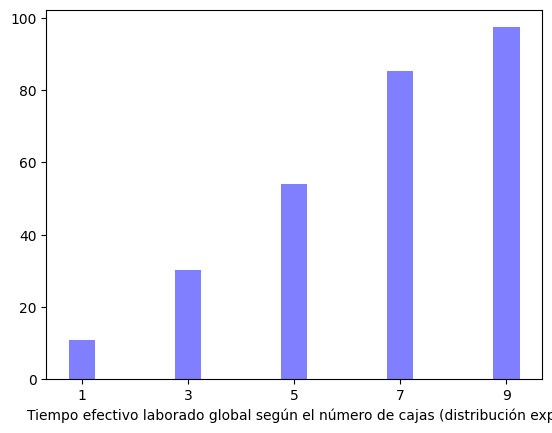

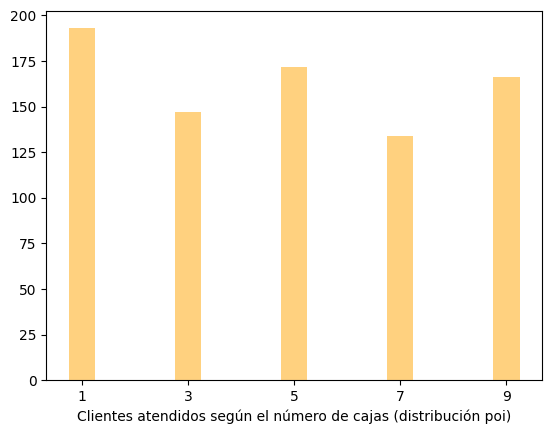

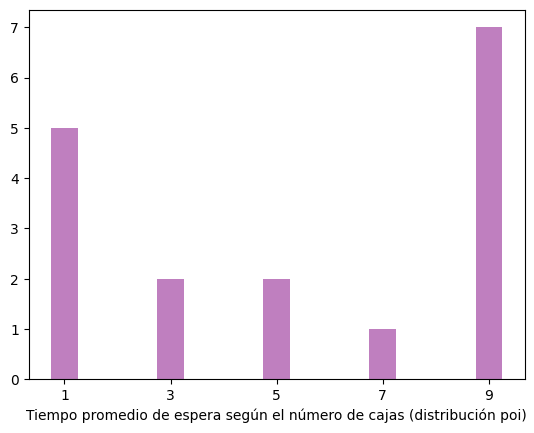

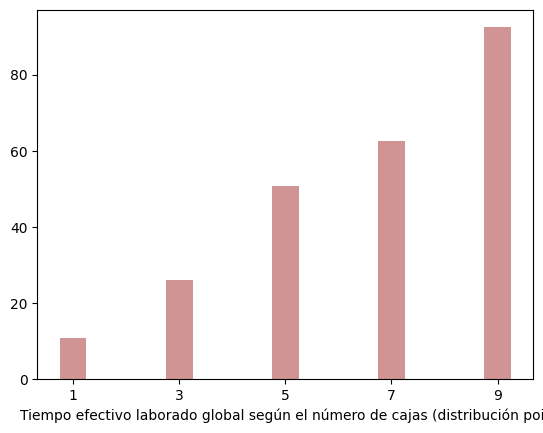

In [33]:
# Se grafican los resultados
ancho_barras = 1 / (len(variables_a_graficar) + 1)
posiciones = numpy.arange(len(numeros_cajas))
colores = colores()

# Crear el directorio para las corridas
try:
    os.mkdir("corridas")
except:
    pass

for distribucion in distribuciones:

    for n_cajas in numeros_cajas:
    
        ejecutar_simulacion(
            entorno = simpy.Environment(),
            duracion_simulacion = duracion_simulacion,
            hora_inicio = hora_inicio,
            dist = distribucion,
            n_servidores = n_cajas,
            lambda_llegada = 12,
            lambda_atencion = 15,
            ruta_archivo_resultados=f"corridas/corrida_{distribucion}_{n_cajas}_cajas.txt"
        )

        cants_clientes_atendidos.append(clientes_atendidos)
        tiempos_promedio_espera.append(int(espera_total/total_clientes))
        # Se suman los tiempos efectivos de cada caja y se transforman a horas
        tiempos_efectivos_globales.append(sum(tiempos_efectivos.values()) / 60)

    for var in variables_a_graficar:
        
        plt.bar(posiciones, var[1], align="center", alpha=0.5, color=next(colores), width=ancho_barras)
        plt.xticks(posiciones, numeros_cajas)
        plt.xlabel(f"{var[0]} (distribución {distribucion})")
        plt.show()
        # Limpiar la lista para la siguiente variable
        var[1].clear()